In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)


In [2]:
import nibabel as nib
import mne
import numpy as np

from cerebra_atlas_python.cerebra import CerebrA
# from cerebra_atlas_python.utils import setup_logging
# setup_logging()

In [3]:
cerebra = CerebrA()

In [4]:
SUBJECT_DIR_FULL = "/home/carlos/Datasets/subjects/"
CEREBRA_DIR_FULL = "/home/carlos/Datasets/Cerebra/"

In [5]:
def inspect_img(path):
    img = nib.load(path)
    data = img.get_fdata()
    img.orthoview()
    print(f"{img.shape= }")
    codes = nib.orientations.aff2axcodes(img.affine)
    print(f"Coordinate frame: {''.join(codes)}")
    return img, data 

img.shape= (193, 229, 193)
Coordinate frame: RAS


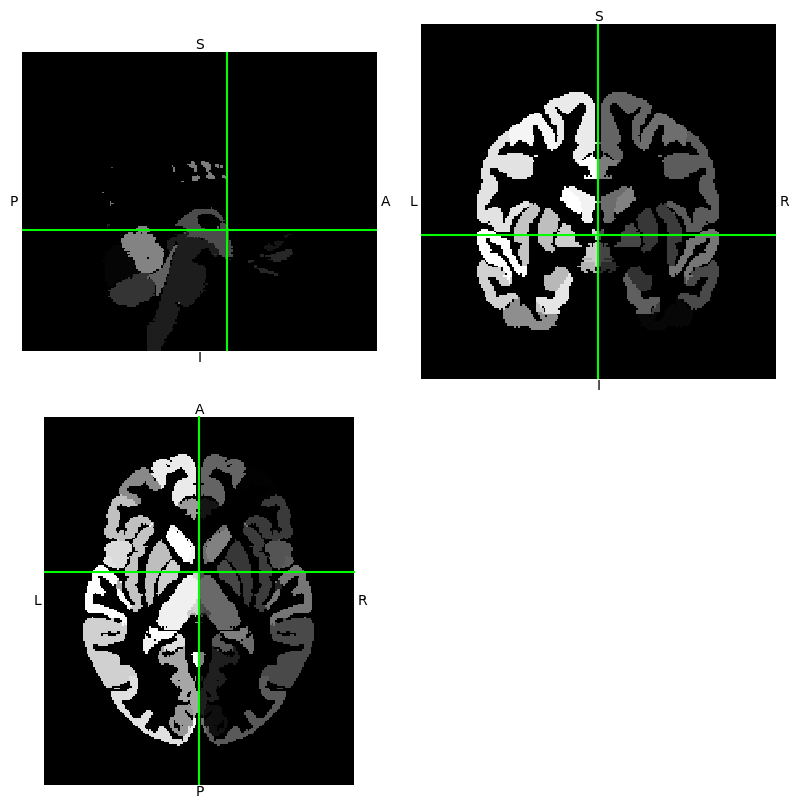

In [6]:
cerebra_nii_img, cerebra_nii_data = inspect_img(f"{CEREBRA_DIR_FULL}/CerebrA.nii")

img.shape= (256, 256, 256)
Coordinate frame: LIA


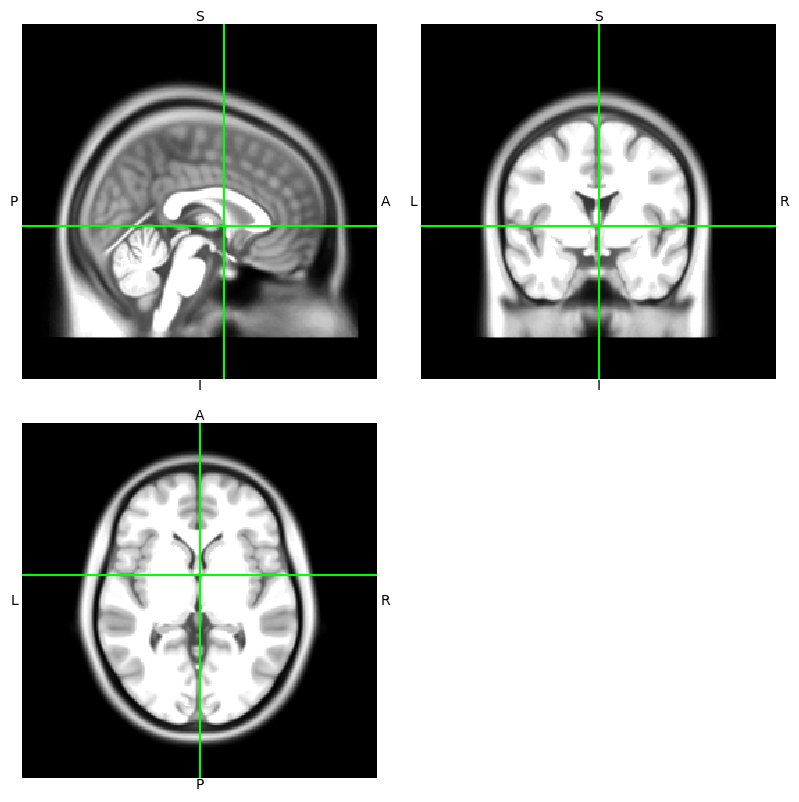

In [7]:
t1_img, t1_data = inspect_img(f"{SUBJECT_DIR_FULL}MNIAverage/mri/T1.mgz")

img.shape= (256, 256, 256)
Coordinate frame: LIA


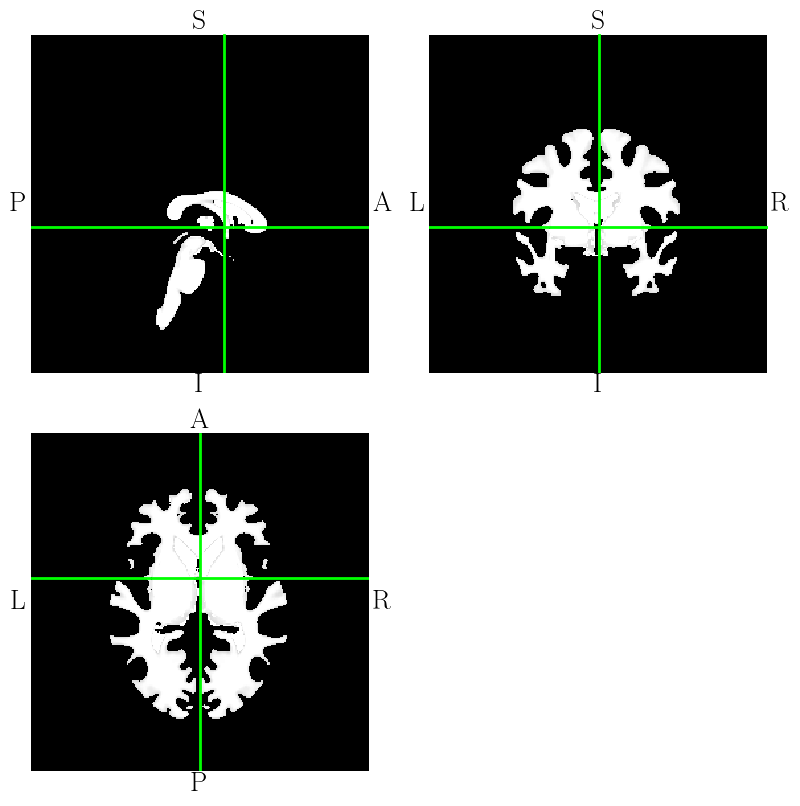

In [32]:
wm_img, wm_data = inspect_img(f"{SUBJECT_DIR_FULL}/MNIAverage/mri/wm.mgz")

img.shape= (256, 256, 256)
Coordinate frame: LIA


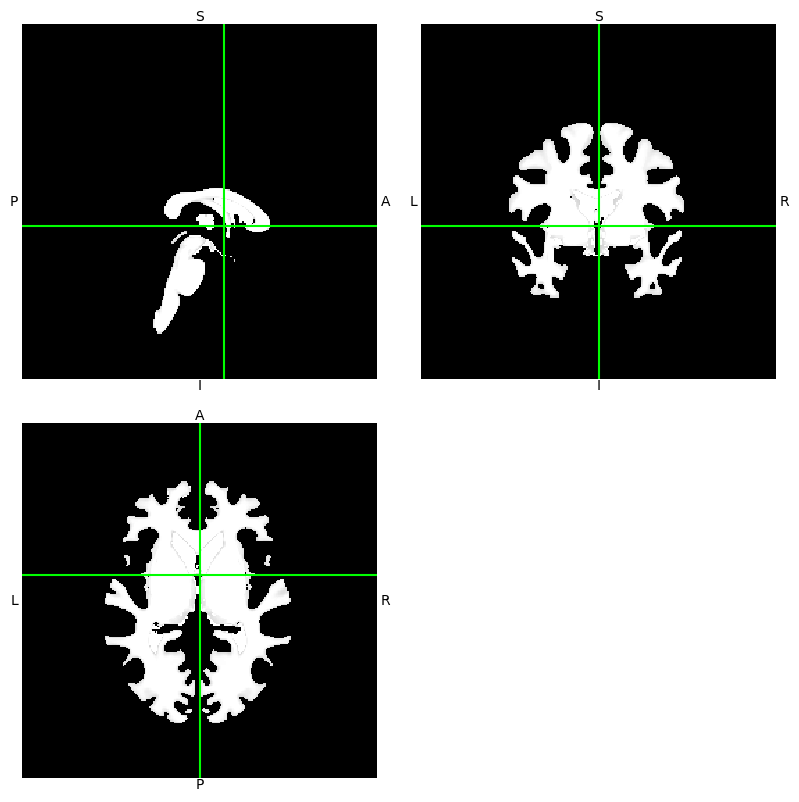

In [9]:
# wm_img, wm_data = inspect_img(f"{SUBJECT_DIR_FULL}/MNIAverage/mri/wm.asegedit.mgz")

### Transform .nii to .mgz

In [10]:
!mri_convert $CEREBRA_DIR_FULL"/CerebrA.nii" $CEREBRA_DIR_FULL"/CerebrA.mgz"

mri_convert /home/carlos/Datasets/Cerebra//CerebrA.nii /home/carlos/Datasets/Cerebra//CerebrA.mgz 
reading from /home/carlos/Datasets/Cerebra//CerebrA.nii...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (0, 0, 1)
writing to /home/carlos/Datasets/Cerebra//CerebrA.mgz...


### Switch to head coordinate frame and store in CerebrA_in_head.mgz

In [11]:
!mri_vol2vol --mov $CEREBRA_DIR_FULL"/CerebrA.mgz" --o $CEREBRA_DIR_FULL"/CerebrA_in_head.mgz" --regheader --targ $SUBJECT_DIR/mri/T1.mgz --interp nearest

movvol /CerebrA.mgz
targvol /mri/T1.mgz
outvol /CerebrA_in_head.mgz
invert 0
tal    0
talres 2
regheader 1
noresample 0
interp  nearest (0)
precision  float (3)
Gdiag_no  -1
Synth      0
SynthSeed  1700577297
error: mghRead(/CerebrA.mgz, -1): could not open file 


img.shape= (193, 229, 193)
Coordinate frame: RAS


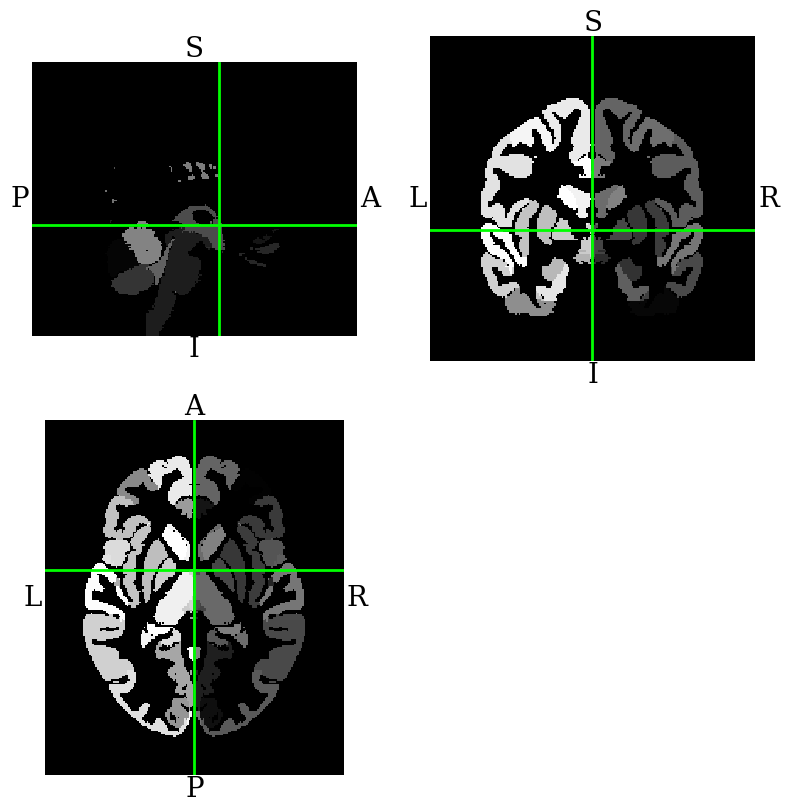

In [12]:
cerebra_mgz_img, cerebra_mgz_data = inspect_img(f"{CEREBRA_DIR_FULL}/CerebrA.mgz")

img.shape= (256, 256, 256)
Coordinate frame: LIA


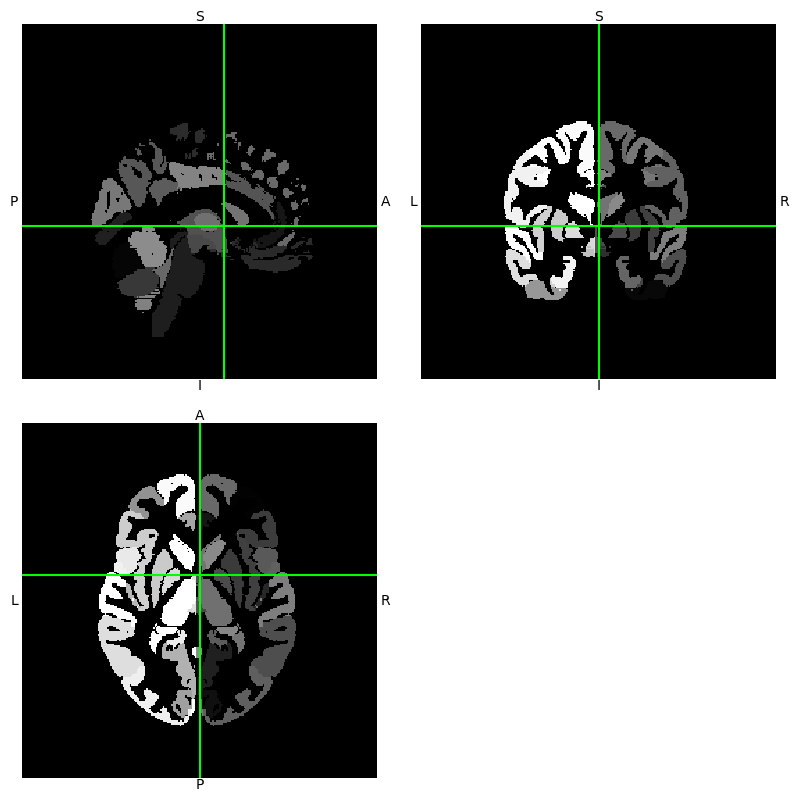

In [21]:
cerebra_in_head_img, cerebra_in_head_data = inspect_img(f"{CEREBRA_DIR_FULL}/CerebrA_in_head.mgz")

# Make sure alignment between cerebra_in_head and wm is accurate


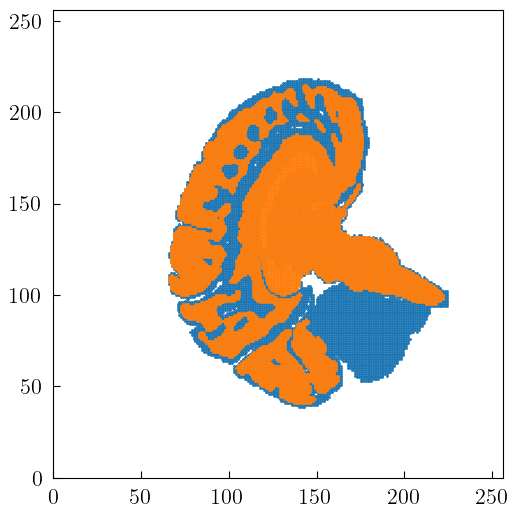

In [34]:
import matplotlib.pyplot as plt
from cerebra_atlas_python.plotting import plot_brain_slice_2d, slice_volume, project_volume_2d,get_2d_fig_ax

data_slice = slice_volume(
            cerebra_in_head_data, fixed_value=120, axis=0, n_layers=10
        )

xs_ys, cs, alphas = project_volume_2d(
    data_slice,
    axis=0
)
xs, ys = xs_ys.T
fig,ax = get_2d_fig_ax()
ax.scatter(xs, ys, c=cs, alpha=alphas, s=1)

data_slice = slice_volume(
            wm_data, fixed_value=120, axis=0, n_layers=10
        )

xs_ys, cs, alphas = project_volume_2d(
    data_slice,
    axis=0
)
xs, ys = xs_ys.T
ax.scatter(xs, ys, c=cs, alpha=alphas, s=1)

### Coordinate frame transforms

In [14]:
from cerebra_atlas_python.plotting import  plot_brain_slice_2D
from cerebra_atlas_python.utils import move_volume_from_LIA_to_RAS
from cerebra_atlas_python.plotting import orthoview

('L', 'I', 'A')


<Axes: xlabel='Y', ylabel='Z'>

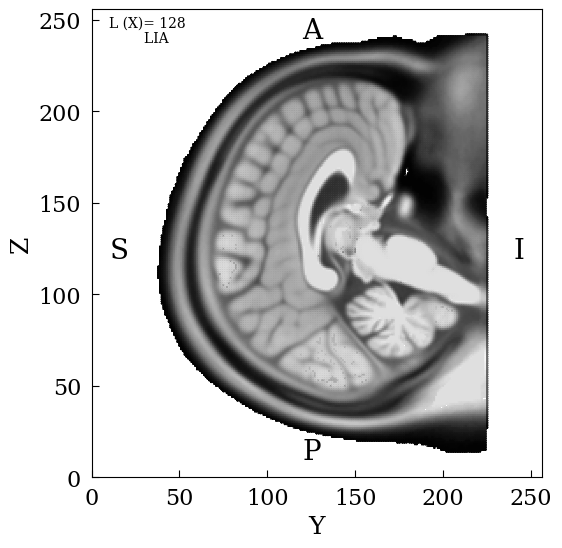

In [15]:
print(nib.orientations.aff2axcodes(t1_img.affine))
plot_brain_slice_2D(t1_data,t1_img.affine)

In [16]:
t1_volume_ras, _ = move_volume_from_LIA_to_RAS(t1_data, t1_img.affine)

After transforming the volume, the affine is not correct and should also be transformed

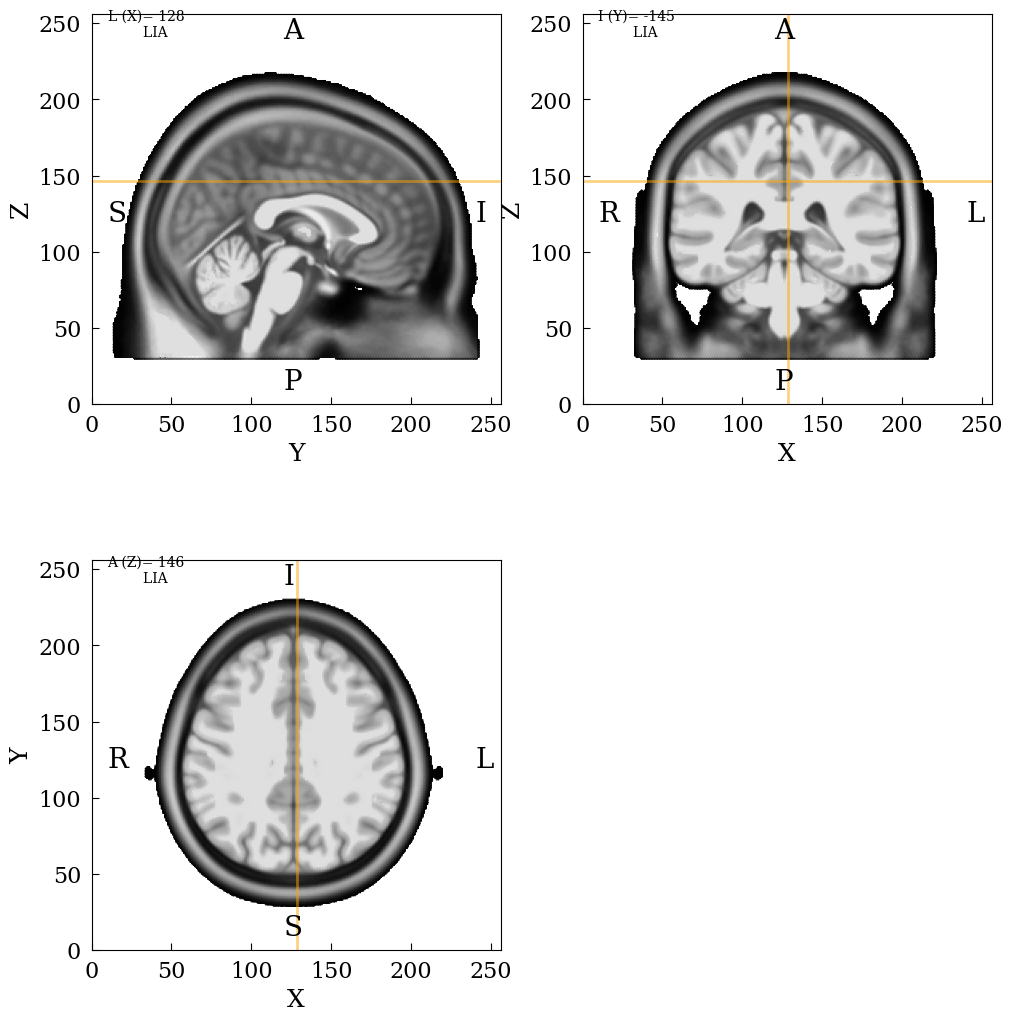

In [17]:
# The affine matrix should also be modified to be in RAS
orthoview(t1_volume_ras, t1_img.affine, cmap_name="gray", plot_affine=True)
pass

In [18]:
print(nib.orientations.aff2axcodes(t1_img.affine))
t1_img.affine

('L', 'I', 'A')


array([[  -1. ,    0. ,    0. ,  128.5],
       [   0. ,    0. ,    1. , -145.5],
       [   0. ,   -1. ,    0. ,  146.5],
       [   0. ,    0. ,    0. ,    1. ]])

In [19]:
print(nib.orientations.aff2axcodes(cerebra_mgz_img.affine))
cerebra_mgz_img.affine

('R', 'A', 'S')


array([[   1.,    0.,    0.,  -96.],
       [   0.,    1.,    0., -132.],
       [   0.,    0.,    1.,  -78.],
       [   0.,    0.,    0.,    1.]])

### Transform affine matrix

Cerebra in head is in same coordinate frame as T1.mgz and wm.mgz 
(Same affine)

In [20]:
aff = wm_img.affine.copy()
print(nib.orientations.aff2axcodes(aff))
aff

('L', 'I', 'A')


array([[  -1. ,    0. ,    0. ,  128.5],
       [   0. ,    0. ,    1. , -145.5],
       [   0. ,   -1. ,    0. ,  146.5],
       [   0. ,    0. ,    0. ,    1. ]])

In [21]:
aff = t1_img.affine.copy()
print(nib.orientations.aff2axcodes(aff))
aff

('L', 'I', 'A')


array([[  -1. ,    0. ,    0. ,  128.5],
       [   0. ,    0. ,    1. , -145.5],
       [   0. ,   -1. ,    0. ,  146.5],
       [   0. ,    0. ,    0. ,    1. ]])

In [22]:
aff = cerebra_in_head_img.affine.copy()
print(nib.orientations.aff2axcodes(aff))
aff

('L', 'I', 'A')


array([[  -1. ,    0. ,    0. ,  128.5],
       [   0. ,    0. ,    1. , -145.5],
       [   0. ,   -1. ,    0. ,  146.5],
       [   0. ,    0. ,    0. ,    1. ]])

In [23]:
# Switch from LIA to RIA
aff[0, 0] = 1
print(nib.orientations.aff2axcodes(aff))
aff

('R', 'I', 'A')


array([[   1. ,    0. ,    0. ,  128.5],
       [   0. ,    0. ,    1. , -145.5],
       [   0. ,   -1. ,    0. ,  146.5],
       [   0. ,    0. ,    0. ,    1. ]])

In [24]:
# Switch from RIA to RSA
aff[1, -1] = 256 - aff[2, -1]
aff[2, 1] = 1
print(nib.orientations.aff2axcodes(aff))
aff

('R', 'S', 'A')


array([[  1. ,   0. ,   0. , 128.5],
       [  0. ,   0. ,   1. , 109.5],
       [  0. ,   1. ,   0. , 146.5],
       [  0. ,   0. ,   0. ,   1. ]])

In [25]:
aff[1:3, :] = np.roll(aff[1:3, :],1,axis=0)
print(nib.orientations.aff2axcodes(aff))
aff

('R', 'A', 'S')


array([[  1. ,   0. ,   0. , 128.5],
       [  0. ,   1. ,   0. , 146.5],
       [  0. ,   0. ,   1. , 109.5],
       [  0. ,   0. ,   0. ,   1. ]])

In [26]:
t1_volume_ras, t1_affine_ras = move_volume_from_LIA_to_RAS(t1_data, t1_img.affine)
t1_affine_ras

array([[  1. ,   0. ,   0. , 126. ],
       [  0. ,   1. ,   0. , 146.5],
       [  0. ,   0. ,   1. , 109.5],
       [  0. ,   0. ,   0. ,   1. ]])

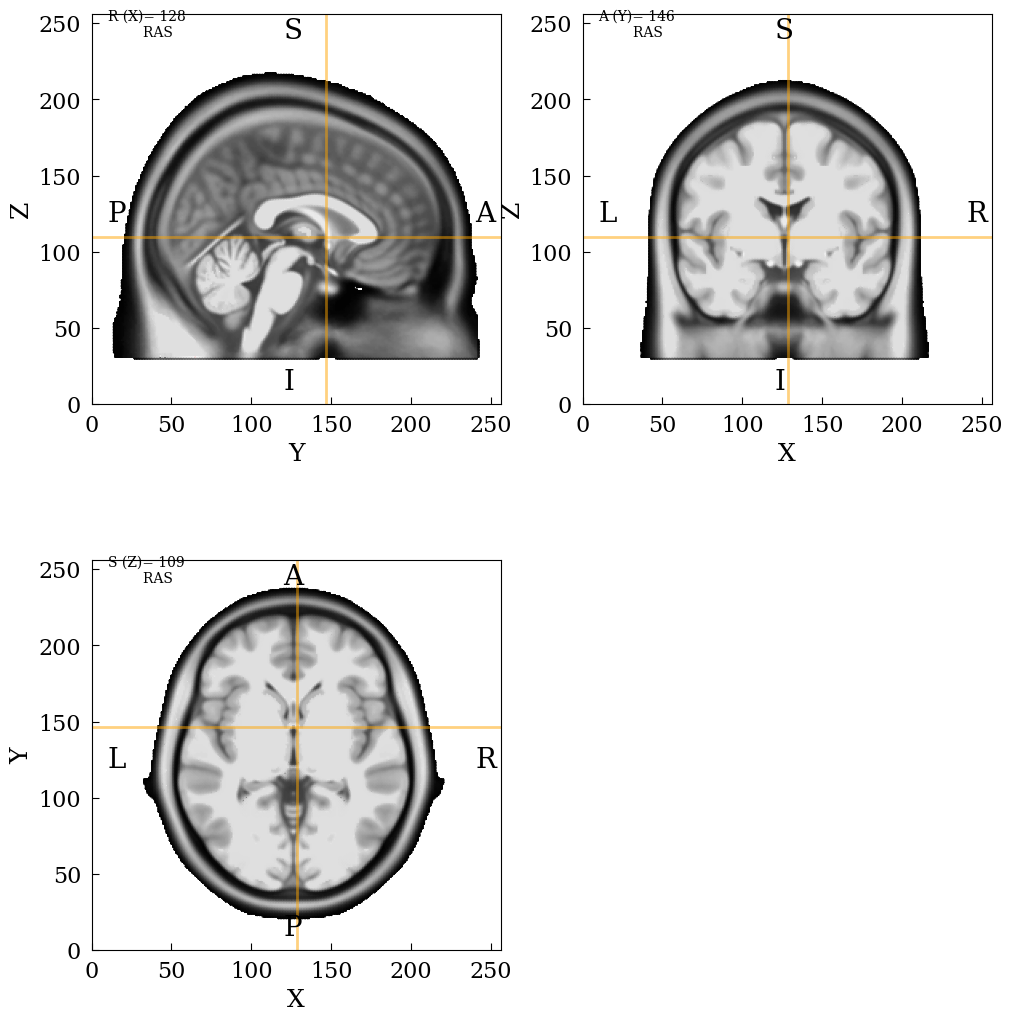

In [27]:
# The affine matrix should also be modified to be in RAS
orthoview(t1_volume_ras, aff, cmap_name="gray", plot_affine=True)
pass

### Adjust affine?

img.shape= (256, 256, 256)
Coordinate frame: LIA


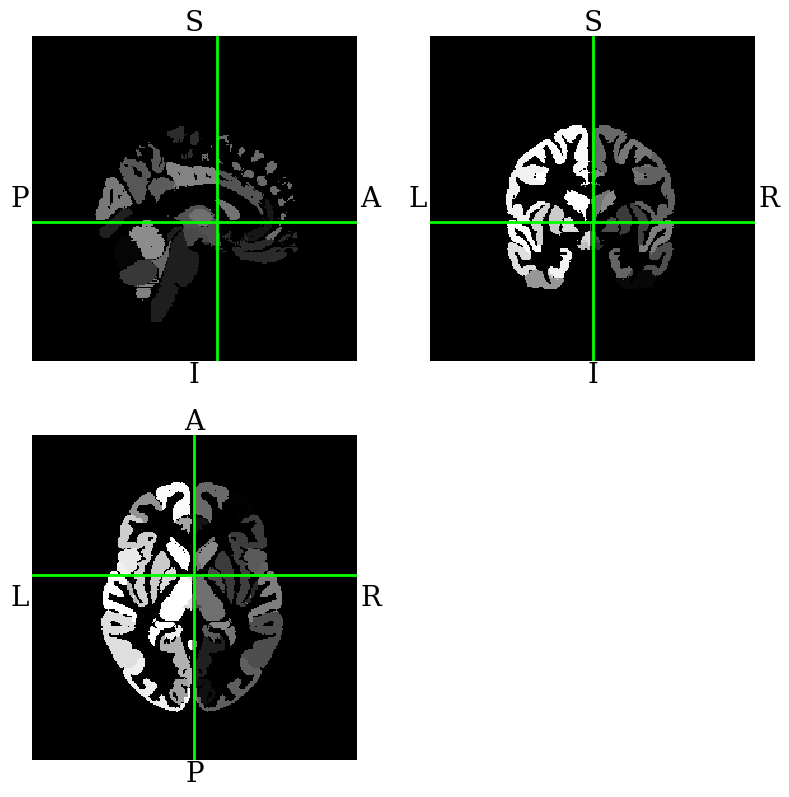

In [28]:
cerebra_in_head_img, cerebra_volume_LIA = inspect_img(f"{CEREBRA_DIR_FULL}/CerebrA_in_head.mgz")
cerebra_volume_RAS, cerebra_affine_RAS = move_volume_from_LIA_to_RAS(cerebra_volume_LIA, cerebra_in_head_img.affine)

In [29]:
def is_left_hemisphere(slice):
    if slice.sum() == 0:
        return False
    # No points from right hemisphere
    check1 = np.logical_and(slice>0, slice<52).sum() == 0
    # Some point from left hemisphere
    check2 = np.logical_and(slice>52, slice<103).sum() != 0
    if check1 != check2:
        raise(f"errrrrr {check1= } {check2= }")
    return check1

In [30]:
# Whats the left hemisphere actual limit
for L in range(-128,-100, 1):
    dat = cerebra_volume_LIA[L, :, :]
    # If right hemisphere continue
    if is_left_hemisphere(dat):
        print(f"{L= } is left brain for cerebra_volume_LIA")
        break
    else:import CerebrA
cerebra = ra_volume_RAS[R, :, :]
    # If right hemisphere continue
    if not is_left_hemisphere(dat):
        print(f"{R= } is right brain for cerebra_volume_RAS")
        break
    else:
        print(f"{R= } is left brain for cerebra_volume_RAS")

# RAS:
# R = 125 is left brain
# R = 126 is right brain

L= -128 is right brain for cerebra_volume_LIA
L= -127 is right brain for cerebra_volume_LIA
L= -126 is left brain for cerebra_volume_LIA
R= 124 is left brain for cerebra_volume_RAS
R= 125 is left brain for cerebra_volume_RAS
R= 126 is right brain for cerebra_volume_RAS


In [31]:
aff_adjusted = aff.copy()
aff_adjustedimport CerebrA
cerebra = 

array([[  1. ,   0. ,   0. , 128.5],
       [  0. ,   1. ,   0. , 146.5],
       [  0. ,   0. ,   1. , 109.5],
       [  0. ,   0. ,   0. ,   1. ]])

(<Figure size 1200x1200 with 4 Axes>,
 array([[<Axes: xlabel='Y', ylabel='Z'>, <Axes: xlabel='X', ylabel='Z'>],
        [<Axes: xlabel='X', ylabel='Y'>, <Axes: >]], dtype=object))

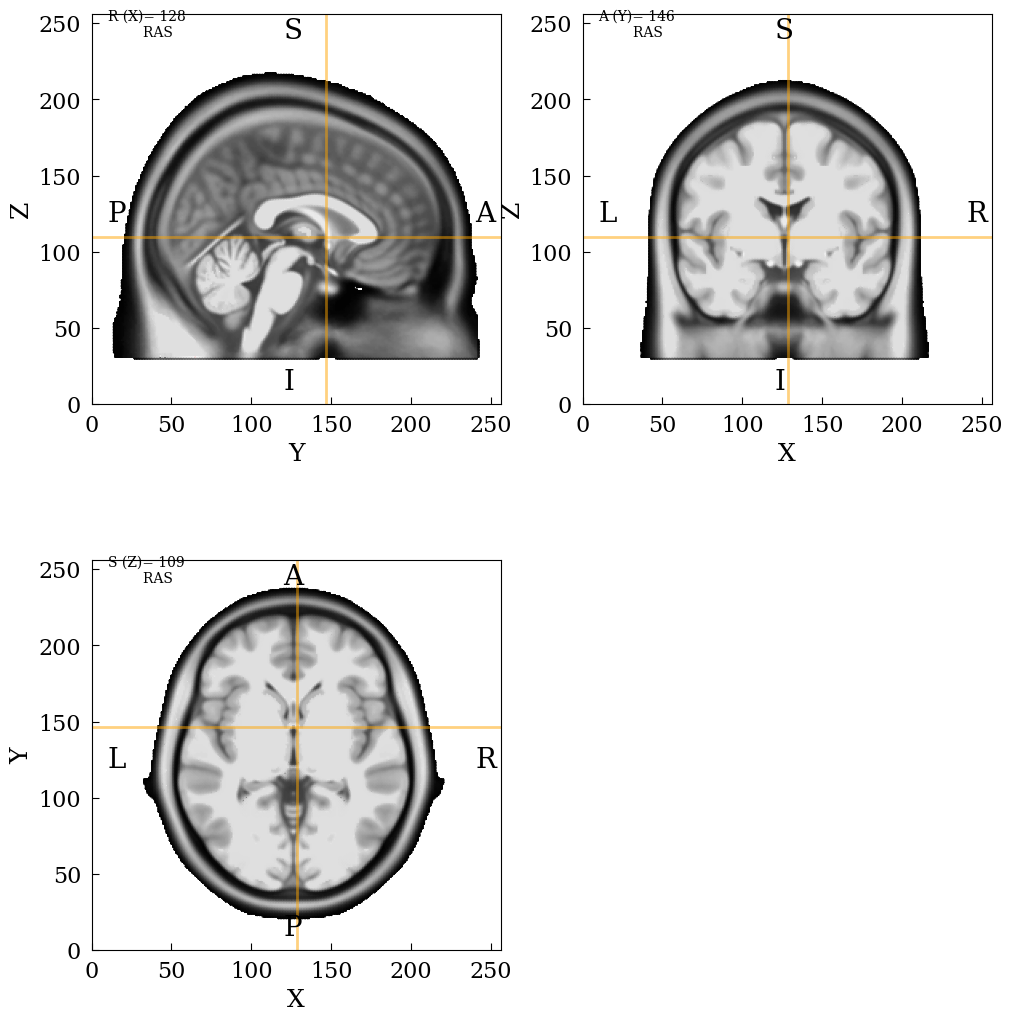

In [32]:
# Not quite aligned
orthoview(t1_volume_ras, aff, cmap_name="gray", plot_affine=True)

In [33]:
aff_adjusted[0, -1] = 126  # Fix translation

(<Figure size 1200x1200 with 4 Axes>,
 array([[<Axes: xlabel='Y', ylabel='Z'>, <Axes: xlabel='X', ylabel='Z'>],
        [<Axes: xlabel='X', ylabel='Y'>, <Axes: >]], dtype=object))

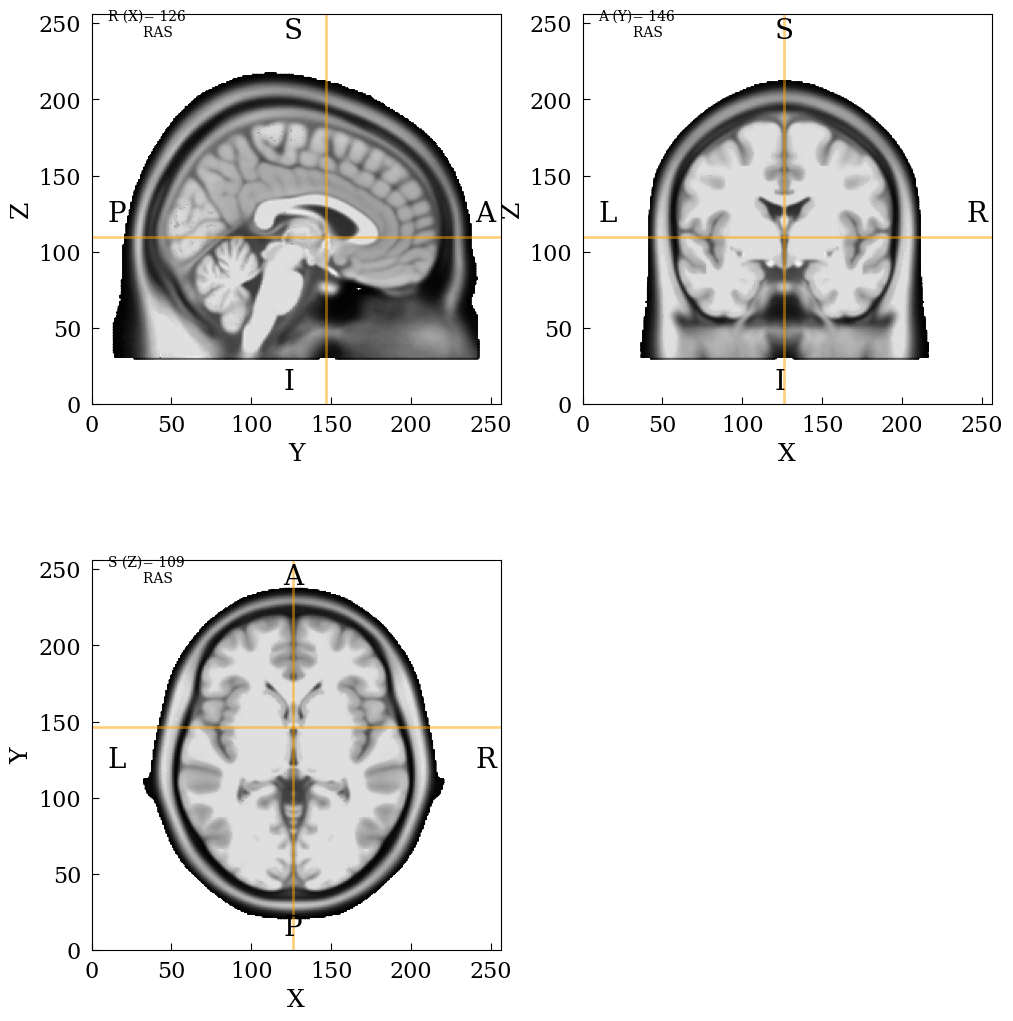

In [34]:
# The bound between right and left hemisphere looks better. Affine has to be
# manually adjusted
orthoview(t1_volume_ras, aff_adjusted, cmap_name="gray", plot_affine=True)

### EVERYTHING IS ALIGNED NOW

(<Figure size 1200x1200 with 4 Axes>,
 array([[<Axes: xlabel='Y', ylabel='Z'>, <Axes: xlabel='X', ylabel='Z'>],
        [<Axes: xlabel='X', ylabel='Y'>, <Axes: >]], dtype=object))

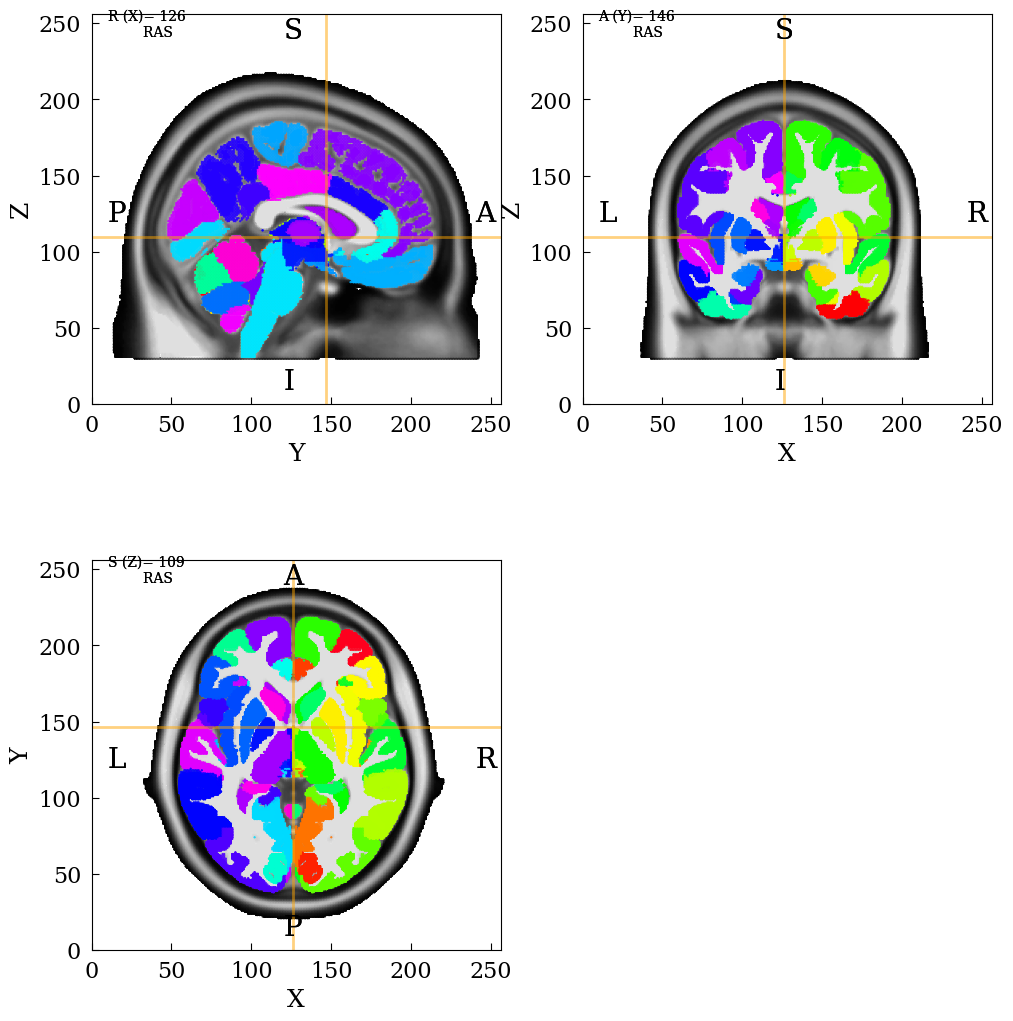

In [35]:
fig, axs = orthoview(t1_volume_ras, aff_adjusted, cmap_name="gray", plot_affine=True)
orthoview(cerebra_volume_RAS, aff_adjusted,fig=fig, axs=axs)